# Tutoriel pour **InfluxDB**

Bienvenue sur ce tutoriel ! Vous allez découvrir les principales fonctionnalitées de InfluxDB, une base de donnée non relationnelle orientée séries temporelles.
Elle peut être utilisée dans de nombreux domaines, en stockant par exemple :
 - les données des capteurs industriels,
 - les métriques de performance des serveurs,
 - les mesures des précipitations,
 - le cours en bourse.

## 🔎 Comment se présente la base de donnée ?

L'équivalent d'une occurance est un *point* qui est composé d'un *timestamp*, *measurement*, *tag keys*, *tag values* et *field key*.
Un groupe de points avec les mêmes mesurements, tags et fields sont appelées des séries temporelles (*time series*)

Les données sont organisées dans des *buckets*. Chaque bucket peut contenir plusieurs mesures (*mesurements*)  différentes.
Une mesure contiennent un timestamp et plusieurs *tags* et *fields*.
Les tags sont des paires clef-valeur dont les valeurs ne changent pas souvent. Ils sont indexés donc ils permettents d'organiser rapidement les données. Par exemple, cela peut être le lieu d'une expérience fixe, ou le nom de l'appareillage.
Les fields sont des paires clef-valeurs qui changent au cours du temps. Ils ne sont pas indexées. Par exemple, cela peut être la température ou la pression mesurée.



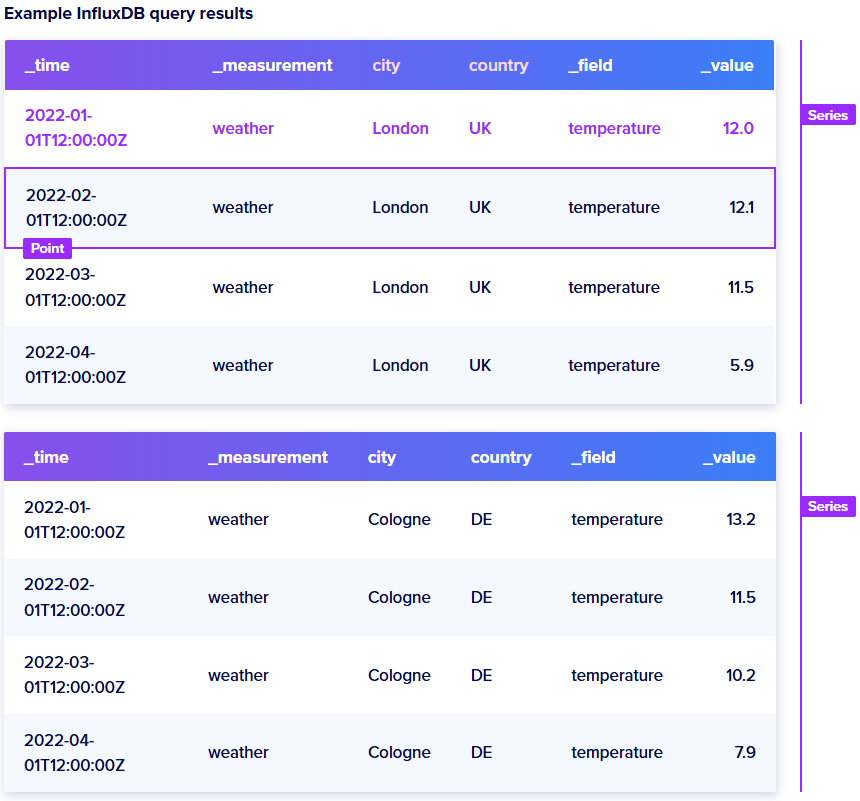
*Source: https://docs.influxdata.com*

In [ ]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
from datetime import datetime
import time

In [2]:
# Paramètres de connexion
url = "http://influxdb:8086"
token = "my-secret-token"
org = "my-org"
bucket = "my-bucket"

In [3]:
# Création du client
client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

print("✅ Connexion réussie à InfluxDB!")

✅ Connexion réussie à InfluxDB!


In [4]:
# Population de la base de données
# Chemin du fichier contenant les données
FILENAME = "data/migration.txt"
print("Population de la base de données avec les données du fichier...", FILENAME)
with open(FILENAME, "r") as file:
    for line in file:
        write_api.write(bucket=bucket, org=org, record=line)
print("Population terminée!")


Population de la base de données avec les données du fichier... data/migration.txt
Population terminée!


### 📊 Insertion de Données
Nous allons insérer une mesure simple (ex: température d'un capteur).


In [5]:
data = "temperature,sensor_id=1 value=22.5"
write_api.write(bucket=bucket, org=org, record=data)
print("✅ Donnée insérée avec succès!")

✅ Donnée insérée avec succès!


Commençons par examiner une line protocol element !

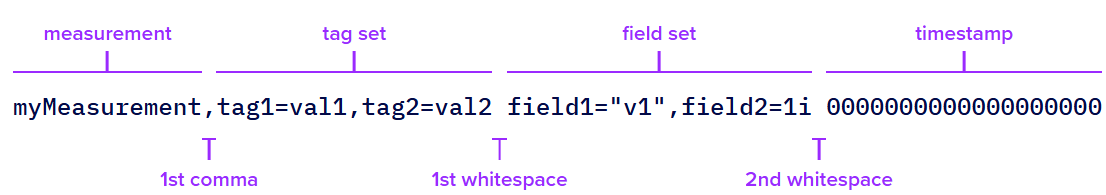

*Source: https://docs.influxdata.com*

A noter :
- il y a des virgules après le mesurement, pour séparer les tags entre eux, et pour séparer les fields entre eux;
- il y a un espace pour séparer les tags des fields, ainsi que les fields et le timestamp;
- les lines sont séparés entre elles par \n;
- si un des attribut à un espace dans son nom, on peut utiliser \ 
    ex: `home,room=Kitchen temp=21.0,hum=35.9,co=0i 1641024000
        home,room=Living\ Room temp=21.4,hum=35.9,co=0i 1641027600`


Pour ce tutoriel, nous utilisons un dataset étudiant la qualité de l'air. Voici un line protocol element :

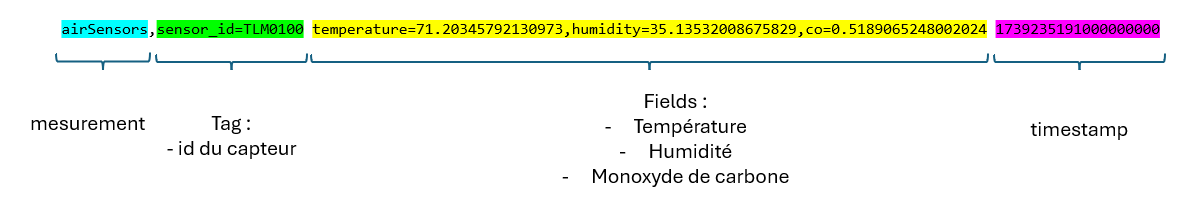

Pour ajouter une ou plusieurs *lines protocol*, on utilise `influx write` :
`

In [13]:
timestamp_ns = int(time.time() * 1_000_000_000)
data = f"airSensors,sensor_id=TLM0100 temperature=71.20345792130973,humidity=35.13532008675829,co=0.5189065248002024 {timestamp_ns}"
# Ajout de la mesure dans notre bucket
write_api.write(bucket=bucket, org=org, record=data)
print("✅ Donnée insérée avec succès!")

✅ Donnée insérée avec succès!


Nous venons donc d'ajouter la donnée que au moment de l'éxécution de la dernière cellule, le capteur TLM0100 a mesuré une température de 71.20345792130973 °F, une humidité de 35.13532008675829 % et un densité de CO de 0.5189065248002024.
Nous allons maintenant visualiser pour vérifier si notre ajout a bien été effectué et que l'on peut voir les trois valeurs (co, humidity et temperature).

In [14]:
query = f'''
from(bucket: "{bucket}")
    |> range(start: -1h)
'''
result = query_api.query(org=org, query=query)

print(f"📊 Résultat : {result}")

for table in result:
    for record in table.records:
        # Affiche tous les champs sur une seule ligne
        print(f"📌 Time: {record['_time']}, Measurement: {record['_measurement']}, Sensor: {record['sensor_id']}, Field: {record['_field']}, Value: {record['_value']}")


print("✅ Requête exécutée avec succès!")

📊 Résultat : [<FluxTable: 9 columns, 2 records>, <FluxTable: 9 columns, 2 records>, <FluxTable: 9 columns, 2 records>, <FluxTable: 9 columns, 1 records>]
📌 Time: 2025-03-11 07:19:57.155825+00:00, Measurement: airSensors, Sensor: TLM0100, Field: co, Value: 0.5189065248002024
📌 Time: 2025-03-11 07:20:20.808099+00:00, Measurement: airSensors, Sensor: TLM0100, Field: co, Value: 0.5189065248002024
📌 Time: 2025-03-11 07:19:57.155825+00:00, Measurement: airSensors, Sensor: TLM0100, Field: humidity, Value: 35.13532008675829
📌 Time: 2025-03-11 07:20:20.808099+00:00, Measurement: airSensors, Sensor: TLM0100, Field: humidity, Value: 35.13532008675829
📌 Time: 2025-03-11 07:19:57.155825+00:00, Measurement: airSensors, Sensor: TLM0100, Field: temperature, Value: 71.20345792130973
📌 Time: 2025-03-11 07:20:20.808099+00:00, Measurement: airSensors, Sensor: TLM0100, Field: temperature, Value: 71.20345792130973
📌 Time: 2025-03-11 07:17:38.781411+00:00, Measurement: temperature, Sensor: 1, Field: value, V

Pour plus de précision :
- -b, --bucket ou --bucket-id permet de préciser le bucket concerné;
- -p, --precision permet de donner la precision du timestamp (s pour les secondes, m pour les minutes,...), Attention, par défault, il s'agit de nanosecondes.

#### ❓ Rajoutez les mesures suivantes :
 - pour la date du 15/02/2025 à 14:30 : le capteur TLM0103 a mesuré une température de 74.56597046148916 °F, une humidité de 34.48544050518988 % et un densité de CO de 0.12410174546713217
 - pour la date du 16/02/2025 à 14:30 : le capteur TLM0202 a mesuré une température de 71.24597046148916 °F, une humidité de 33.71944373469555 % et un densité de CO de 0.6329052625629839

In [15]:
from datetime import datetime

# Créer un objet datetime à partir d'une date précise
date_str_1 = "2025-02-15 14:30:00"  # Format: "YYYY-MM-DD HH:MM:SS"
date_1 = datetime.strptime(date_str_1, "%Y-%m-%d %H:%M:%S")

# Convertir cette date en timestamp (nanosecondes)
timestamp_ns_1 = int(date_1.timestamp() * 1_000_000_000)


date_str_2 = "2025-02-16 14:30:00"
date_2 = datetime.strptime(date_str_2, "%Y-%m-%d %H:%M:%S")
timestamp_ns_2 = int(date_2.timestamp() * 1_000_000_000)

# Ajout des nouvelles mesures
data_1 = f"airSensors,sensor_id=TLM0103 temperature=74.56597046148916,humidity=34.48544050518988,co=0.12410174546713217 {timestamp_ns_1}"
data_2 = f"airSensors,sensor_id=TLM0202 temperature=71.24597046148916,humidity=33.71944373469555,co=0.6329052625629839 {timestamp_ns_2}"

# Écriture des nouvelles mesures dans le bucket
write_api.write(bucket=bucket, org=org, record=data_1)
write_api.write(bucket=bucket, org=org, record=data_2)

print("✅ Nouvelles données insérées avec succès!")

✅ Nouvelles données insérées avec succès!


Executez le script suivant pour vérifier que votre ajout à fonctionné. Vous deviriez avoir :

In [16]:
query=f'''
from(bucket: "{bucket}")
  |> range(start: 2025-01-01T00:00:00Z , stop: 2026-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "airSensors")
'''

result = query_api.query(org=org, query=query)
print(result)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")

print("✅ Requête exécutée avec succès!")

[<FluxTable: 9 columns, 2 records>, <FluxTable: 9 columns, 2 records>, <FluxTable: 9 columns, 2 records>, <FluxTable: 9 columns, 1 records>, <FluxTable: 9 columns, 1 records>, <FluxTable: 9 columns, 1 records>, <FluxTable: 9 columns, 1 records>, <FluxTable: 9 columns, 1 records>, <FluxTable: 9 columns, 1 records>]
📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2025, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2026, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2025, 3, 11, 7, 19, 57, 155825, tzinfo=datetime.timezone.utc), '_value': 0.5189065248002024, '_field': 'co', '_measurement': 'airSensors', 'sensor_id': 'TLM0100'}
📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2025, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2026, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2025, 3, 11, 7, 20, 20, 808099, tzinfo=datetime.timezone.utc), '_value': 0.51890652480020

Si tu as fait trop de requête et que tu veux un bucket vide pour pouvoir tester d'avantage, executes ce code : 

In [ ]:
from influxdb_client import InfluxDBClient
from datetime import datetime

buckets_api = client.buckets_api()
bucket_obj = buckets_api.find_bucket_by_name(bucket)

if bucket_obj:
    buckets_api.delete_bucket(bucket_obj)
    print(f"✅ Bucket '{bucket}' supprimé avec succès !")
else:
    print(f"⚠️ Bucket '{bucket}' introuvable !")

buckets_api.create_bucket(bucket_name=bucket, org=org)

✅ Bucket 'mybucket' supprimé avec succès !


{'created_at': datetime.datetime(2025, 3, 9, 12, 12, 18, 679773, tzinfo=tzlocal()),
 'description': None,
 'id': 'bba7e65be87fc0de',
 'labels': [],
 'links': {'_self': '/api/v2/buckets/bba7e65be87fc0de',
           'labels': '/api/v2/buckets/bba7e65be87fc0de/labels',
           'members': '/api/v2/buckets/bba7e65be87fc0de/members',
           'org': '/api/v2/orgs/2db5b9a91b895401',
           'owners': '/api/v2/buckets/bba7e65be87fc0de/owners',
           'write': '/api/v2/write?org=2db5b9a91b895401&bucket=bba7e65be87fc0de'},
 'name': 'mybucket',
 'org_id': '2db5b9a91b895401',
 'retention_rules': [{'every_seconds': 0,
                      'shard_group_duration_seconds': 604800,
                      'type': 'expire'}],
 'rp': '0',
 'schema_type': None,
 'type': 'user',
 'updated_at': datetime.datetime(2025, 3, 9, 12, 12, 18, 679774, tzinfo=tzlocal())}

### 📖 Lecture des Données
Nous allons récupérer les données insérées à l'aide d'une requête. Nous utilisons ici des requêtes de type Flux mais d'autres types de requête sont possibles, notamment des requêtes utilisant InfluxQL, dont la syntaxe ressemble à celle du SQL.


Les données traitées en utilisant InfluxDB sont souvent des données en temps réel, c'est pourquoi range permet de spécifier une période par rapport au moment présent (ici : -1h). Mais il est aussi possible de spécifier la période via un timecode.  
InfluxDB utilise l'opérande |> pour indiquer que la sortie de la requête est utilisée comme entrée pour la fonction à appliquer.

In [35]:
query = f"""
from(bucket: "{bucket}")
|> range(start: -1h)
"""

result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")

print("✅ Requête exécutée avec succès!")


📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2025, 3, 10, 10, 37, 14, 308125, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 37, 14, 308125, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2025, 3, 10, 11, 4, 40, 355942, tzinfo=datetime.timezone.utc), '_value': 22.5, '_field': 'value', '_measurement': 'temperature', 'sensor_id': '1'}
📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2025, 3, 10, 10, 37, 14, 308125, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 37, 14, 308125, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2025, 3, 10, 11, 36, 6, 994909, tzinfo=datetime.timezone.utc), '_value': 22.5, '_field': 'value', '_measurement': 'temperature', 'sensor_id': '1'}
✅ Requête exécutée avec succès!


In [75]:
query = f"""
from(bucket: "{bucket}")
|> range(start: 1554000000, stop: 1560000000)
"""

result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")

print("✅ Requête exécutée avec succès!")

📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2019, 3, 31, 2, 40, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2019, 6, 8, 13, 20, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2019, 4, 1, 13, 0, tzinfo=datetime.timezone.utc), '_value': 8.3495, '_field': 'lat', '_measurement': 'migration', 'id': '91752A', 's2_cell_id': '164b35c'}
📌 {'result': '_result', 'table': 1, '_start': datetime.datetime(2019, 3, 31, 2, 40, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2019, 6, 8, 13, 20, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2019, 4, 1, 13, 0, tzinfo=datetime.timezone.utc), '_value': 39.01233, '_field': 'lon', '_measurement': 'migration', 'id': '91752A', 's2_cell_id': '164b35c'}
📌 {'result': '_result', 'table': 2, '_start': datetime.datetime(2019, 3, 31, 2, 40, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2019, 6, 8, 13, 20, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2019, 4, 1, 7, 0, tzinfo=dat

Il est bien évidemment possible de filtrer les lignes via d'autres attribut grâce à "filter" qui prend en paramètre une fonction.  
Ici on ne récupère que les lignes ayant un id spécifique.

In [72]:
query = f"""
from(bucket: "{bucket}")
|> range(start: 0)
|> filter(fn: (r) => r.id == "91752A")
"""

result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")

print("✅ Requête exécutée avec succès!")

📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 17, 26, 18, 891237, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2019, 4, 1, 13, 0, tzinfo=datetime.timezone.utc), '_value': 8.3495, '_field': 'lat', '_measurement': 'migration', 'id': '91752A', 's2_cell_id': '164b35c'}
📌 {'result': '_result', 'table': 1, '_start': datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 17, 26, 18, 891237, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2019, 4, 1, 13, 0, tzinfo=datetime.timezone.utc), '_value': 39.01233, '_field': 'lon', '_measurement': 'migration', 'id': '91752A', 's2_cell_id': '164b35c'}
📌 {'result': '_result', 'table': 2, '_start': datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 17, 26, 18, 891237, tzinfo=datetime.timezone.utc), '_time': datetime.date

On peut utiliser plusieurs filter ainsi que les mots-clés and ou or.

In [ ]:
query = f"""
from(bucket: "{bucket}")
|> range(start: 0)
  |> filter(fn: (r) => r._measurement == "migration")  
  |> filter(fn: (r) => r._field == "lat")  // Récupère uniquement les latitudes  
  |> filter(fn: (r) => r._value > 7.8 and r._value < 8.0)
"""

result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")

print("✅ Requête exécutée avec succès!")

### Process Data

Nous allons maintenant voir différents traitements qu'il est possible d'effectuer.
Il est notamment possible d'utiliser map pour traiter les données.

In [36]:
query = f"""
from(bucket: "{bucket}")
|> range(start: 2019-01-15T00:00:00Z)
|> filter(fn: (r) => r._measurement == "migration")
|> filter(fn: (r) => r._field == "lat")
|> map(fn: (r) => ({{
    _time: r._time, 
    _measurement: r._measurement, 
    _field: "lat_radians", 
    _value: r._value * 3.141592653589793 / 180.0
}}))
|> limit(n: 50)
"""

result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")

print("✅ Requête exécutée avec succès!")

📌 {'result': '_result', 'table': 0, '_field': 'lat_radians', '_value': 0.14572626589526655, '_time': datetime.datetime(2019, 4, 1, 13, 0, tzinfo=datetime.timezone.utc), '_measurement': 'migration'}
📌 {'result': '_result', 'table': 0, '_field': 'lat_radians', '_value': 0.14941187767670297, '_time': datetime.datetime(2019, 4, 1, 7, 0, tzinfo=datetime.timezone.utc), '_measurement': 'migration'}
📌 {'result': '_result', 'table': 0, '_field': 'lat_radians', '_value': 0.13722354537832576, '_time': datetime.datetime(2019, 1, 15, 13, 0, tzinfo=datetime.timezone.utc), '_measurement': 'migration'}
📌 {'result': '_result', 'table': 0, '_field': 'lat_radians', '_value': 0.137584304934713, '_time': datetime.datetime(2019, 3, 20, 7, 0, tzinfo=datetime.timezone.utc), '_measurement': 'migration'}
📌 {'result': '_result', 'table': 0, '_field': 'lat_radians', '_value': 0.13722354537832576, '_time': datetime.datetime(2019, 3, 27, 7, 0, tzinfo=datetime.timezone.utc), '_measurement': 'migration'}
📌 {'result':

Il est possible de rajouter des statuts qui détectent lorsqu'un threshold est dépassé.

In [48]:
query = f"""
from(bucket: "{bucket}")
|> range(start: 2019-05-10T20:00:00Z)
|> filter(fn: (r) => r._measurement == "migration")
|> filter(fn: (r) => r.id == "91864A")
|> filter(fn: (r) => r._field == "lat")
|> map(fn: (r) => ({{ r with state: if r._value < 35 then "en dessous de la Méditerranée" else "au dessus de la Méditerranée" }}))
|> limit(n: 50)
"""


result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")

print("✅ Requête exécutée avec succès!")

📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2019, 5, 10, 20, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 47, 4, 766931, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2019, 8, 31, 8, 0, tzinfo=datetime.timezone.utc), '_value': 40.4005, '_field': 'lat', '_measurement': 'migration', 'id': '91864A', 's2_cell_id': '14b58b4', 'state': 'au dessus de la Méditerranée'}
📌 {'result': '_result', 'table': 1, '_start': datetime.datetime(2019, 5, 10, 20, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 47, 4, 766931, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2019, 8, 31, 14, 0, tzinfo=datetime.timezone.utc), '_value': 38.727, '_field': 'lat', '_measurement': 'migration', 'id': '91864A', 's2_cell_id': '14c7e34', 'state': 'au dessus de la Méditerranée'}
📌 {'result': '_result', 'table': 2, '_start': datetime.datetime(2019, 5, 10, 20, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(

Il est possible de faire des group by.

In [45]:
query = f"""
from(bucket: "{bucket}")
|> range(start: 2019-01-15T00:00:00Z)
|> filter(fn: (r) => r._measurement == "migration")
|> filter(fn: (r) => r._field == "lat")
|> group(columns: ["id"])
|> mean()
|> limit(n: 50)
"""

result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")
      
print("✅ Requête exécutée avec succès!")

📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2019, 1, 15, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 43, 48, 704750, tzinfo=datetime.timezone.utc), 'id': '91752A', '_value': 8.055198854092525}
📌 {'result': '_result', 'table': 1, '_start': datetime.datetime(2019, 1, 15, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 43, 48, 704750, tzinfo=datetime.timezone.utc), 'id': '91761A', '_value': 4.992517369791666}
📌 {'result': '_result', 'table': 2, '_start': datetime.datetime(2019, 1, 15, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 43, 48, 704750, tzinfo=datetime.timezone.utc), 'id': '91763A', '_value': -1.2327422333571938}
📌 {'result': '_result', 'table': 3, '_start': datetime.datetime(2019, 1, 15, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 43, 48, 704750, tzinfo=datetime.timezone.utc), 'id': '91814A', '_value': -0.88691148982558

Une spécificité de InfluxDB est le pivot pivot pour le traitement des données. Il permet de relier les données d'une colonne à une autre colonne. Par exemple, si vous avez une colonne de données de latitude et une colonne de données de longitude, vous pouvez les relier pour obtenir une seule colonne de données de latitude et de longitude.

In [46]:
query = f"""
from(bucket: "{bucket}")
|> range(start: 2019-01-15T00:00:00Z)
|> filter(fn: (r) => r._measurement == "migration")
|> filter(fn: (r) => r._field == "lat" or r._field == "lon")
|> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
|> limit(n: 50)
"""

result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")
      
print("✅ Requête exécutée avec succès!")

📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2019, 1, 15, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 44, 27, 777867, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2019, 4, 1, 13, 0, tzinfo=datetime.timezone.utc), '_measurement': 'migration', 'id': '91752A', 's2_cell_id': '164b35c', 'lat': 8.3495, 'lon': 39.01233}
📌 {'result': '_result', 'table': 1, '_start': datetime.datetime(2019, 1, 15, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 44, 27, 777867, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2019, 4, 1, 7, 0, tzinfo=datetime.timezone.utc), '_measurement': 'migration', 'id': '91752A', 's2_cell_id': '164b3dc', 'lat': 8.56067, 'lon': 39.08883}
📌 {'result': '_result', 'table': 2, '_start': datetime.datetime(2019, 1, 15, 0, 0, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 3, 10, 11, 44, 27, 777867, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(

### ❌ Fermeture de la connexion
Toujours fermer la connexion après utilisation pour libérer les ressources.


In [49]:
client.close()
print("✅ Connexion fermée.")

✅ Connexion fermée.


### Visualisation des données
Il est possible de visualiser graphiquement ces données grâce à une interface et d'y faire tout types de manipulations.

Dans ce tutoriel, nous utilisons Chronograf, l'interface graphique d'InfluxDB.

Pour y accéder, il suffit de se rendre à l'adresse suivante : http://localhost:8888
Vous pouvez ensuite vous connecter avec les identifiants suivants :
- Cocher la case "InfluxDB v2 Auth"
- Connection URL : http://influxdb:8086
- Organization: my-org
- Token: my-secret-token

Puis sélectionner le *dashboard* InfluxDB
Passer l'étape *Kapacitor Connection*

#### Vous pouvez naviguer au sein de l'interface et explorer ses possibilités